In [1]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *

import torch.linalg as LA

from models import *
from transformers import GPT2Model, GPT2Config
from notebook_utils import *

import matplotlib.pyplot as plt

In [2]:
mytf_tm, dataset = load_mytfs_model_and_dataset(
    embed_dim = 33,
    num_vars = 16,
    attention_style = "softmax",
    do_layer_norm = False,
    seed = 507,
    chain_len_range = (3,3),
    num_rules_range = (8,12))

for k, v in mytf_tm.named_parameters():
    print(k)

mytf.af_blocks.0.attn_heads.0.Wq.weight
mytf.af_blocks.0.attn_heads.0.Wk.weight
mytf.af_blocks.0.attn_heads.0.Wv.weight
mytf.af_blocks.0.ffwd.0.weight
mytf.af_blocks.0.ffwd.2.weight


In [3]:
mytf = mytf_tm.mytf
af = mytf.af_blocks[0]
Wq, Wk, Wv = af.attn_heads[0].Wq, af.attn_heads[0].Wk, af.attn_heads[0].Wv
_Wq = Wq.weight.transpose(0,1).detach()
_Wk = Wk.weight.transpose(0,1).detach()
_Wv = Wv.weight.transpose(0,1).detach()

lin1 = af.ffwd[0]
lin2 = af.ffwd[2]
_lin1 = lin1.weight.detach()
_lin2 = lin2.weight.detach()

torch.tensor([
    [_Wq.min(), _Wq.max()],
    [_Wk.min(), _Wk.max()],
    [_Wv.min(), _Wv.max()],
    [_lin1.min(), _lin1.max()],
    [_lin2.min(), _lin2.max()]
])

tensor([[-1.4260,  1.5212],
        [-1.5734,  1.6321],
        [-1.2310,  1.2415],
        [-1.0045,  1.0747],
        [-0.6654,  0.7603]])

<Figure size 640x480 with 0 Axes>

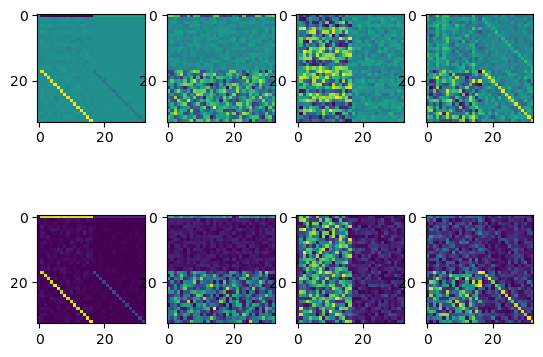

In [4]:
plt.clf()
fig, ax = plt.subplots(2,4)

ax[0,0].imshow((_Wq @ _Wk.transpose(0,1)).numpy())
ax[0,1].imshow(_Wq.numpy())
ax[0,2].imshow(_Wk.transpose(0,1).numpy())
ax[0,3].imshow(_Wv.numpy())

ax[1,0].imshow((_Wq @ _Wk.transpose(0,1)).abs().numpy())
ax[1,1].imshow(_Wq.abs().numpy())
ax[1,2].imshow(_Wk.transpose(0,1).abs().numpy())
ax[1,3].imshow(_Wv.abs().numpy())

<Figure size 640x480 with 0 Axes>

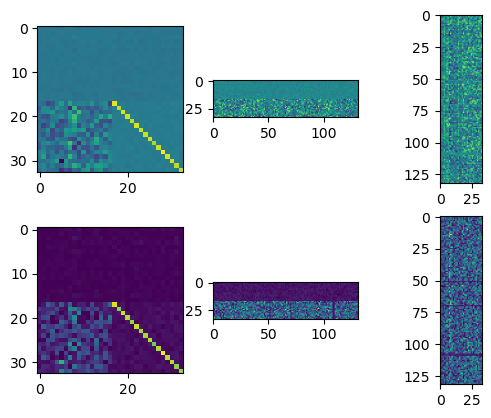

In [5]:
plt.clf()
fig, ax = plt.subplots(2,3)

ax[0,0].imshow((_lin2 @ _lin1).numpy())
ax[0,1].imshow(_lin2.numpy())
ax[0,2].imshow(_lin1.numpy())

ax[1,0].imshow((_lin2 @ _lin1).abs().numpy())
ax[1,1].imshow(_lin2.abs().numpy())
ax[1,2].imshow(_lin1.abs().numpy())

In [6]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [7]:
torch.manual_seed(101)
for item in DataLoader(dataset, batch_size=5):
    break

out = mytf_tm(**item)
pred = out.logits > 0
(pred == item["labels"]).float().mean(dim=-1).squeeze()

tensor([1., 1., 1., 1., 1.])

In [8]:
item["tokens"].shape

torch.Size([5, 15, 32])

In [9]:
tokens = item["tokens"]
x = torch.cat([
    torch.ones(tokens.size(0), tokens.size(1), 1),
    tokens
], dim=2)

wts, A = af(x)

# A = (Wq(x) @ Wk(x).transpose(1,2)).detach()
# wts = (A @ Wv(x)).detach()

# x_emb_norm = af.norm1(x_emb).detach()
# A = (Wq(x_emb_norm) @ Wk(x_emb_norm).transpose(1,2)).detach()
# wts = (A @ Wv(x_emb_norm)).detach()


In [10]:
item["labels"]

tensor([[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]])

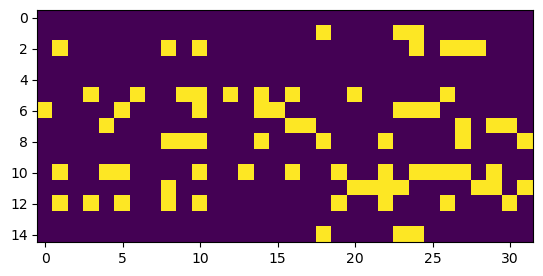

In [11]:
plt.imshow(tokens[-1].detach().numpy())

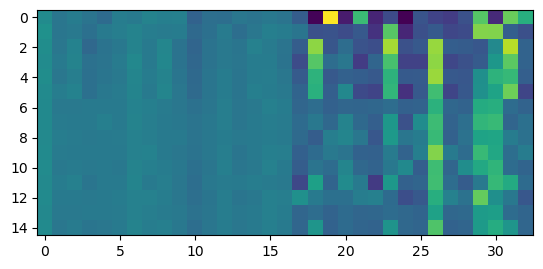

In [12]:
plt.imshow(wts[0].detach().numpy())

In [13]:
af(x)

(tensor([[[  6.0697,  -2.4506,   0.2539,  ..., -27.9722,  32.8227,  19.6461],
          [  8.2747,  -2.4390,  -1.1826,  ...,  36.7250, -10.6614, -16.3536],
          [  6.7452,  -1.8964,   2.2890,  ...,   4.8266,  44.4146,  -9.2174],
          ...,
          [  5.6418,  -1.0615,  -0.7404,  ...,   7.3125,  -1.4761, -13.8198],
          [  4.6212,  -1.4195,  -1.1848,  ...,  13.2658,  -6.1595,  -8.5434],
          [  5.5994,  -1.8819,  -0.1735,  ...,  18.8856,   9.8103,  -8.3640]],
 
         [[  5.5392,  -3.4008,  -4.1714,  ...,  -5.6736,  -8.7497,   4.6147],
          [  5.6402,  -2.2140,  -2.1071,  ..., -13.0134,  13.9674,  -3.6725],
          [  5.1789,  -2.6741,  -2.1268,  ...,  -8.7747,   0.4906,  -1.9886],
          ...,
          [  2.5250,  -2.2275,  -4.1288,  ...,  -5.1756,  -4.3084,   0.9741],
          [  3.2985,  -1.9942,  -3.8428,  ...,  -8.2471,  -9.8876,  15.5610],
          [  3.8401,  -2.4263,  -3.4318,  ...,  -7.4051,  -6.3947,  21.1098]],
 
         [[  9.0121,  -8.491